# Pipeline CNN + unsupervised on already existing states

### libraires

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

## Récupérer le modèle + dataset nettoyés et combinés


In [ ]:
FILE_HPC = "HPC1.csv"  # Ton fichier avec la colonne hpc
FILE_PFC = "PFC1.csv"  # Ton fichier avec la colonne pfc
MODEL_PATH = "meilleur_cnn_cerveau_multi_rats.keras"

# Paramètres
FS = 500
WINDOW_SIZE = 500

## Mapping pour que ca soit interressant

In [ ]:
# IMPORTANT : Le mapping inverse.
# Ton modèle sort des index : 0, 1, 2, 3, 4
# Tes vrais labels étaient : 0, 1, 3, 4, 5
# Il faut dire au script comment traduire.
# Modifie ceci si tes labels originaux étaient différents.
MAPPING_LABELS = {
    0: 0,
    1: 1,
    2: 3, # L'index 2 du modèle correspond à ton label 3
    3: 4,
    4: 5
}

# MAPPING 2 : Vrai Label -> Couleur et Nom (Pour le graphique)
# 1: Wake, 3: NREM, 4: Intermediate, 5: REM
STATE_CONFIG = {
    0: {'color': 'white',      'name': 'Autre/Artefact', 'alpha': 0.0},
    1: {'color': '#FFD700',    'name': 'Wake (1)',       'alpha': 0.3}, # Or
    3: {'color': '#1E90FF',    'name': 'NREM (3)',       'alpha': 0.3}, # Bleu
    4: {'color': '#A9A9A9',    'name': 'Intermediate (4)','alpha': 0.3}, # Gris
    5: {'color': '#32CD32',    'name': 'REM (5)',        'alpha': 0.3}  # Vert
}

MODEL_TO_REAL_LABEL = MAPPING_LABELS

## Merge les fichiers

In [ ]:
"""
def load_and_merge_data():
    print("1. Chargement et fusion des fichiers...")
    # On suppose que les fichiers n'ont qu'une colonne ou qu'on prend la première
    df_h = pd.read_csv(FILE_HPC)
    df_p = pd.read_csv(FILE_PFC)

    # Vérification de la taille
    min_len = min(len(df_h), len(df_p))

    # Création du DataFrame fusionné
    # On renomme les colonnes pour que ça matche avec ce que le CNN attend
    df_merged = pd.DataFrame({
        'hpc_500': df_h.iloc[:min_len, 0], # Prend la 1ère colonne
        'pfc_500': df_p.iloc[:min_len, 0]  # Prend la 1ère colonne
    })

    return df_merged
  """


'\ndef load_and_merge_data():\n    print("1. Chargement et fusion des fichiers...")\n    # On suppose que les fichiers n\'ont qu\'une colonne ou qu\'on prend la première\n    df_h = pd.read_csv(FILE_HPC)\n    df_p = pd.read_csv(FILE_PFC)\n\n    # Vérification de la taille\n    min_len = min(len(df_h), len(df_p))\n\n    # Création du DataFrame fusionné\n    # On renomme les colonnes pour que ça matche avec ce que le CNN attend\n    df_merged = pd.DataFrame({\n        \'hpc_500\': df_h.iloc[:min_len, 0], # Prend la 1ère colonne\n        \'pfc_500\': df_p.iloc[:min_len, 0]  # Prend la 1ère colonne\n    })\n\n    return df_merged\n  '

In [ ]:
def load_and_merge_data():
    print("1. Chargement dataset_500Hz...")

    # Chargement du fichier complet
    df = pd.read_csv("dataset_500Hz_1.csv")

    # Vérification des colonnes
    expected_cols = ["hpc_500", "pfc_500"]
    for col in expected_cols:
        if col not in df.columns:
            raise ValueError(f"Colonne manquante dans dataset_500Hz : {col}")

    if "manual_500" in df.columns:
        print("→ Colonne 'manual_500' détectée : elle sera ignorée pour l’inférence.")

    # On garde uniquement les deux colonnes nécessaires
    df_clean = df[["hpc_500", "pfc_500"]]

    print(f"Dataset chargé : {len(df_clean)} échantillons.")

    return df_clean


## Prédiction

In [ ]:
def get_predictions(df, model):
    print("2. Prédiction des états...")

    n_windows = len(df) // WINDOW_SIZE
    limit = n_windows * WINDOW_SIZE

    # Préparer entrée
    X_input = df[['hpc_500', 'pfc_500']].iloc[:limit].values.reshape(n_windows, WINDOW_SIZE, 2)

    # Prédictions
    probs = model.predict(X_input, verbose=1)
    indices = np.argmax(probs, axis=1)

    # Index -> Label réel
    labels_1hz = [MODEL_TO_REAL_LABEL[int(i)] for i in indices]

    # 👉 Étendre à la résolution originale (500 Hz)
    labels_full = np.repeat(labels_1hz, WINDOW_SIZE)

    return df.iloc[:limit], labels_1hz, labels_full

## affichage

In [ ]:
def plot_colored_signals(df, labels_per_sec):
    print("3. Génération des graphiques...")

    time_axis = np.arange(len(df)) / FS # Axe temps en secondes
    hpc_signal = df['hpc_500'].values
    pfc_signal = df['pfc_500'].values

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

    # --- Fonction utilitaire pour dessiner les blocs de couleur ---
    def add_background_colors(ax):
        # On parcourt les labels seconde par seconde pour trouver les changements d'état
        # Cela évite de tracer 1000 rectangles pour 1000 secondes de sommeil continu
        current_state = labels_per_sec[0]
        start_sec = 0

        for t, state in enumerate(labels_per_sec):
            if state != current_state:
                # L'état vient de changer, on dessine le rectangle précédent
                cfg = STATE_CONFIG.get(current_state, {'color':'white', 'alpha':0})
                ax.axvspan(start_sec, t, color=cfg['color'], alpha=cfg['alpha'], lw=0)

                # Reset
                current_state = state
                start_sec = t

        # Dessiner le dernier bloc
        cfg = STATE_CONFIG.get(current_state, {'color':'white', 'alpha':0})
        ax.axvspan(start_sec, len(labels_per_sec), color=cfg['color'], alpha=cfg['alpha'], lw=0)

    # --- Plot 1 : HPC ---
    add_background_colors(ax1) # On met les couleurs EN DESSOUS
    ax1.plot(time_axis, hpc_signal, color='black', linewidth=0.5, label='Signal Brut')
    ax1.set_ylabel('Amplitude HPC')
    ax1.set_title('Signal Hippocampe (HPC) avec Classification')

    # --- Plot 2 : PFC ---
    add_background_colors(ax2)
    ax2.plot(time_axis, pfc_signal, color='black', linewidth=0.5, label='Signal Brut')
    ax2.set_ylabel('Amplitude PFC')
    ax2.set_title('Signal Préfrontal (PFC) avec Classification')
    ax2.set_xlabel('Temps (secondes)')

    # --- Légende commune ---
    # On crée des "faux" rectangles juste pour la légende
    patches = []
    for label_id, cfg in STATE_CONFIG.items():
        if label_id != 0: # On ignore le label 0/Artefact si tu veux
            patch = mpatches.Patch(color=cfg['color'], label=cfg['name'], alpha=cfg['alpha'])
            patches.append(patch)

    fig.legend(handles=patches, loc='upper right', title="États de Vigilance")

    plt.tight_layout()
    plt.show()

# Execution

1. Chargement dataset_500Hz...
→ Colonne 'manual_500' détectée : elle sera ignorée pour l’inférence.
Dataset chargé : 1371500 échantillons.
2. Prédiction des états...
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step
✔ CSV final exporté : dataset_predicted.csv
3. Génération des graphiques...


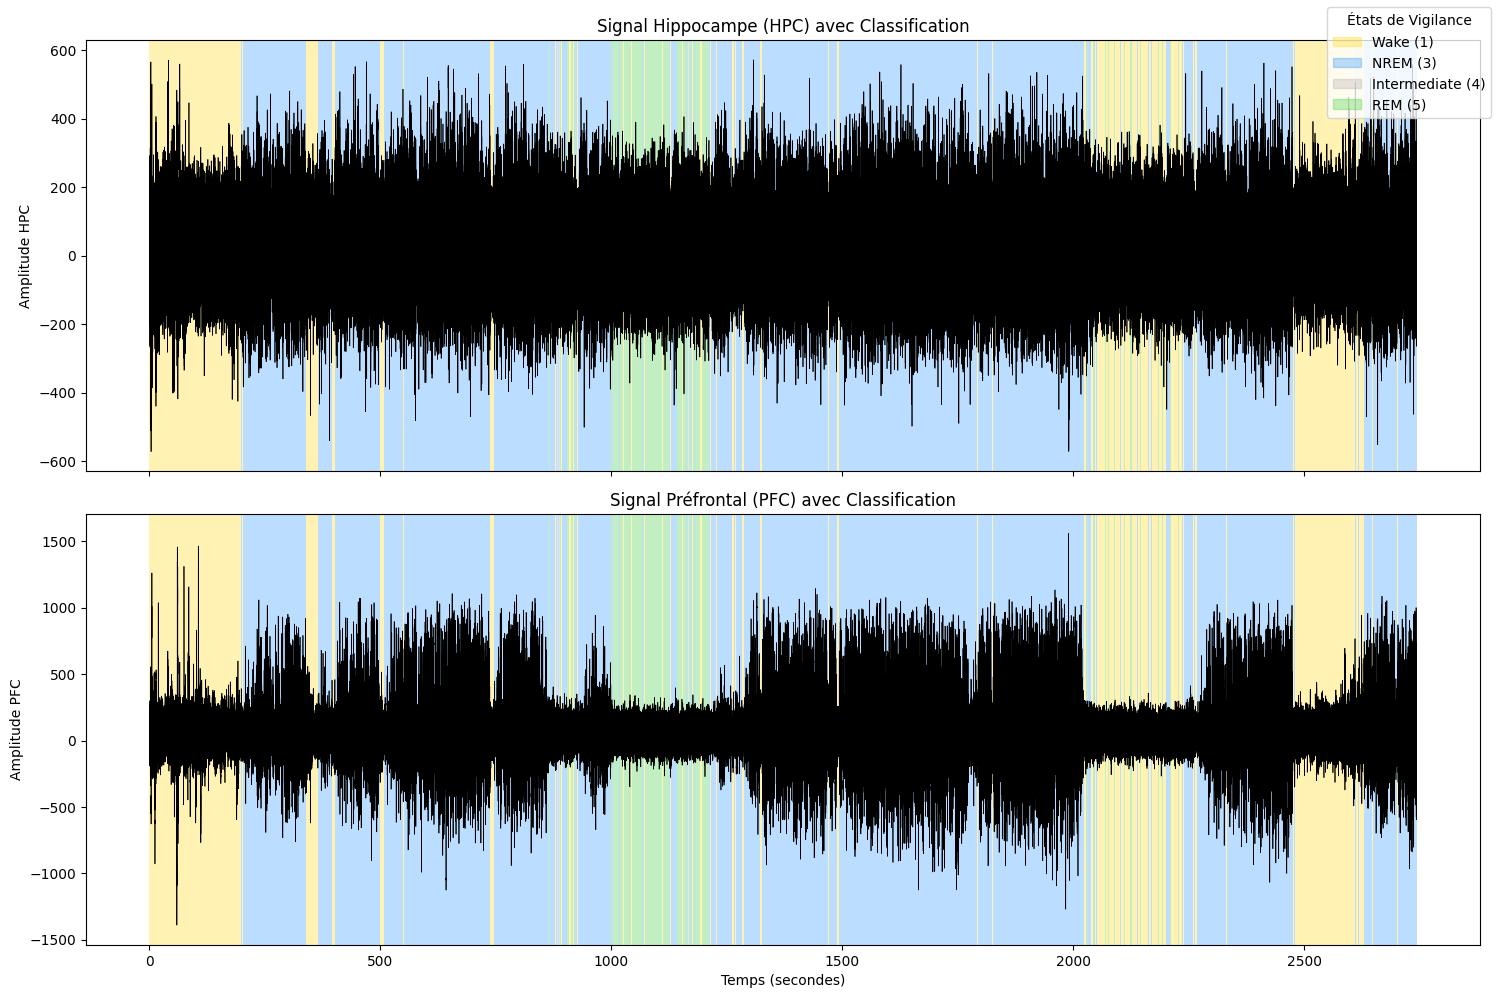

In [ ]:
if __name__ == "__main__":
    model = tf.keras.models.load_model(MODEL_PATH)

    df_merged = load_and_merge_data()

    # 👉 Maintenant retourne aussi labels_full (500 Hz)
    df_cropped, labels_1hz, labels_full = get_predictions(df_merged, model)

    # ------ EXPORT CSV ------
    df_output = df_cropped.copy()
    df_output['predicted_state'] = labels_full
    df_output.to_csv("dataset_predicted.csv", index=False)
    print("✔ CSV final exporté : dataset_predicted.csv")

    # ------ VISUALISATION ------
    limit_view_sec = 10000
    points_view = min(limit_view_sec * FS, len(df_cropped))

    plot_colored_signals(df_cropped.iloc[:points_view], labels_1hz[:limit_view_sec])


In [ ]:
predicted = pd.read_csv("dataset_predicted.csv")
predicted.head()

,hpc_500,pfc_500,predicted_state
0,62.844705,51.656355,1
1,137.740828,57.758723,1
2,80.019974,23.671246,1
3,89.810803,39.607111,1
4,58.157103,64.048580,1
